In [1]:
#importing required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#importing the dataset
df = pd.read_csv("E-Commerce_Reviews.csv").head(300)
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
#shape of the dataset
df.shape

(300, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               300 non-null    int64 
 1   Clothing ID              300 non-null    int64 
 2   Age                      300 non-null    int64 
 3   Title                    234 non-null    object
 4   Review Text              288 non-null    object
 5   Rating                   300 non-null    int64 
 6   Recommended IND          300 non-null    int64 
 7   Positive Feedback Count  300 non-null    int64 
 8   Division Name            300 non-null    object
 9   Department Name          300 non-null    object
 10  Class Name               300 non-null    object
dtypes: int64(6), object(5)
memory usage: 25.9+ KB


In [5]:
#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review Text'].astype(str).str.lower())

In [6]:
#tokenizing the sentences
total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(df['Review Text'].astype(str))

In [7]:
#seperating sequences into n-gram sequence
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)

In [8]:
#pre pad with max sequence length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [9]:
#creating predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
#impoting the model
model = Sequential()
model.add(Embedding(total_words, 30, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(total_words, activation='softmax'))

In [11]:
#compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#earlystopping
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=4, verbose=0, mode='auto')

In [13]:
#fitting the model
history = model.fit(xs, ys, epochs=40, verbose=1, callbacks=[earlystop])

Train on 17388 samples
Epoch 1/40
17388/17388 [==============================] - 201s 12ms/sample - loss: 6.1322 - accuracy: 0.0527
Epoch 2/40
17388/17388 [==============================] - 198s 11ms/sample - loss: 5.6223 - accuracy: 0.0818
Epoch 3/40
17388/17388 [==============================] - 197s 11ms/sample - loss: 5.1705 - accuracy: 0.1175
Epoch 4/40
17388/17388 [==============================] - 197s 11ms/sample - loss: 4.7989 - accuracy: 0.1377
Epoch 5/40
17388/17388 [==============================] - 197s 11ms/sample - loss: 4.4379 - accuracy: 0.1586
Epoch 6/40
17388/17388 [==============================] - 195s 11ms/sample - loss: 4.0784 - accuracy: 0.1798
Epoch 7/40
17388/17388 [==============================] - 196s 11ms/sample - loss: 3.7222 - accuracy: 0.2102
Epoch 8/40
17388/17388 [==============================] - 197s 11ms/sample - loss: 3.3866 - accuracy: 0.2520
Epoch 9/40
17388/17388 [==============================] - 196s 11ms/sample - loss: 3.0630 - accuracy: 0.3

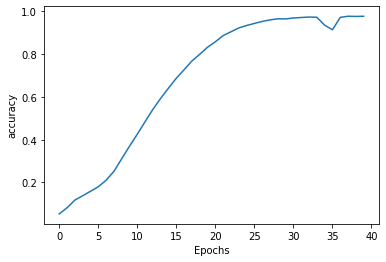

In [14]:
#plotting the result of epocs
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, 'accuracy')

In [15]:
#function to predict the sentence
def complete_this_paragraph(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [16]:
#candidate string for BLEU score
candidate = []
candidate.append(complete_this_paragraph("this is a good", 40))

In [17]:
#taking only Review Text column
df_test = df['Review Text'].astype('str')

In [27]:
#reference string for BLEU score
reference = []
reference.append(df_test[128])

In [29]:
#checking the BLEU score
from nltk.translate.bleu_score import corpus_bleu
bleu_score = corpus_bleu(reference, candidate)
print(float(bleu_score))

1.0518351895246305e-231
